# Unet baseline with MC dropout

In [1]:
import os
import sys
import time
import math
import logging
import warnings
import numpy as np
from glob import glob

# supress regular warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR) 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# supress tensorflow warnings
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# adjust for time step embedding layer
tf.config.run_functions_eagerly(True)

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu

## Hyperparameters

In [3]:
norm_groups = 8 # number of attention heads, number of layer normalization groups 

# min-max values of the diffusion target (learning target) 
clip_min = -1.0
clip_max = 1.0

widths = [64, 96, 128, 256] # number of convolution kernels per up-/downsampling level
feature_sizes = [32, 16, 8, 4]

left_attention = [False, True, True, True] # True: use multi-head attnetion on each up-/downsampling level
right_attention = [False, True, True, True]
num_res_blocks = 2  # Number of residual blocks

input_shape = (32, 32, 8) # the tensor shape of reverse diffusion input
gfs_shape = (128, 128, 8) # the tensor shape of GFS embeddings

F_y = 1/6.3 # the scale of VQ-VAE codes

N_atten1 = np.sum(left_attention)
N_atten2 = np.sum(right_attention)

load_weights = True

# location of the previous weights
model_name = '/glade/work/ksha/GAN/models/Baseline_atten{}-{}_res{}_tune2/'.format(
    N_atten1, N_atten2, num_res_blocks)

# location for saving new weights
model_name_save = '/glade/work/ksha/GAN/models/Baseline_atten{}-{}_res{}_tune3/'.format(
    N_atten1, N_atten2, num_res_blocks)

lr = 1e-5 # learning rate

# samples per epoch = N_batch * batch_size
epochs = 99999
N_batch = 128
batch_size = 32

## Model design

In [4]:
def build_model(input_shape, gfs_shape, widths, feature_sizes, left_attention, right_attention, num_res_blocks=2, norm_groups=8,
                interpolation='bilinear', activation_fn=keras.activations.relu,):

    first_conv_channels = widths[0]
    
    image_input = layers.Input(shape=input_shape, name="image_input")
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")
    gfs_input = layers.Input(shape=gfs_shape, name="gfs_input")
    
    x = layers.Conv2D(first_conv_channels, kernel_size=(3, 3), padding="same",
                      kernel_initializer=mu.kernel_init(1.0),)(image_input)

    temb = mu.TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = mu.TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    has_attention = left_attention
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = mu.ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            x = layers.Dropout(0.2)(x, training=True)
            
            if has_attention[i]:
                # GFS cross-attention inputs
                size_ = feature_sizes[i]
                x_gfs = gfs_input
                x_gfs = layers.Resizing(size_, size_, interpolation='bilinear')(x_gfs)

                x_gfs = layers.Conv2D(int(0.5*widths[i]), kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)

                x_gfs = layers.Conv2D(widths[i], kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)
                
                x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[i])(x, x_gfs)
                
            skips.append(x)

        if widths[i] != widths[-1]:
            x = mu.DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = mu.ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])
    x = layers.Dropout(0.2)(x, training=True)
    
    size_ = feature_sizes[-1]
    x_gfs = gfs_input
    x_gfs = layers.Resizing(size_, size_, interpolation='bilinear')(x_gfs)
    
    x_gfs = layers.Conv2D(int(0.5*widths[-1]), kernel_size=(3, 3), padding="same",)(x_gfs)
    x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
    x_gfs = activation_fn(x_gfs)

    x_gfs = layers.Conv2D(widths[-1], kernel_size=(3, 3), padding="same",)(x_gfs)
    x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
    x_gfs = activation_fn(x_gfs)
    
    x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[-1])(x, x_gfs)
    
    x = mu.ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)([x, temb])
    x = layers.Dropout(0.2)(x, training=True)
    
    # UpBlock
    has_attention = right_attention
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = mu.ResidualBlock(widths[i], groups=norm_groups, activation_fn=activation_fn)([x, temb])
            x = layers.Dropout(0.2)(x, training=True)
            
            if has_attention[i]:
                
                # GFS cross-attention inputs
                size_ = feature_sizes[i]
                x_gfs = gfs_input
                x_gfs = layers.Resizing(size_, size_, interpolation='bilinear')(x_gfs)

                x_gfs = layers.Conv2D(int(0.5*widths[i]), kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)

                x_gfs = layers.Conv2D(widths[i], kernel_size=(3, 3), padding="same",)(x_gfs)
                x_gfs = layers.GroupNormalization(groups=norm_groups)(x_gfs)
                x_gfs = activation_fn(x_gfs)
                
                x = layers.MultiHeadAttention(num_heads=norm_groups, key_dim=widths[i])(x, x_gfs)
                
        if i != 0:
            x = mu.UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(input_shape[-1], (3, 3), padding="same", kernel_initializer=mu.kernel_init(0.0))(x)
    return keras.Model([image_input, time_input, gfs_input], x, name="unet")


In [5]:
# Reverse diffusino model
model = build_model(input_shape=input_shape, gfs_shape=gfs_shape, widths=widths,
                    feature_sizes=feature_sizes, left_attention=left_attention, right_attention=right_attention, 
                    num_res_blocks=num_res_blocks, norm_groups=norm_groups, activation_fn=keras.activations.relu)

# Compile the mdoel
model.compile(loss=keras.losses.MeanAbsoluteError(), optimizer=keras.optimizers.Adam(learning_rate=lr),)

# load previous weights
if load_weights:
    W_old = mu.dummy_loader(model_name)
    model.set_weights(W_old)

## Validation set preparation

In [6]:
L_valid = 270 # number of validation samples

# locations of training data
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_Baseline/'

# preparing training batches
filenames = np.array(sorted(glob(BATCH_dir+'*2023*.npy')))

L = len(filenames)
filename_valid = filenames[::1000][:L_valid]

I_valid = np.empty((L_valid,)+input_shape)
Y_valid = np.empty((L_valid,)+input_shape)
X_valid = np.empty((L_valid,)+gfs_shape)
t_valid = np.empty((L_valid,))

for i, name in enumerate(filename_valid):
    temp_data = np.load(name, allow_pickle=True)[()]
    X_valid[i, ...] = temp_data['data']
    Y_valid[i, ...] = F_y*temp_data['Y_latent']
    I_valid[i, ...] = F_y*temp_data['Y_latent_gfs']
    t_valid[i] = int(name[-25:-23])


In [7]:
pred_ = model.predict([I_valid, t_valid, X_valid])

9/9 [==============================] - 10s 466ms/step


## Training loop

In [8]:
# collect all training batches
filenames = np.array(sorted(glob(BATCH_dir+'*.npy')))
filename_valid = np.array(sorted(glob(BATCH_dir+'*2023*.npy')))
filename_train = list(set(filenames) - set(filename_valid))
L_train = len(filename_train)

In [9]:
L_train/128/32

217.425048828125

In [10]:
min_del = 0.0
max_tol = 3 # early stopping with 2-epoch patience
tol = 0

Y_batch = np.empty((batch_size,)+input_shape)
I_batch = np.empty((batch_size,)+input_shape)
X_batch = np.empty((batch_size,)+gfs_shape)
t_batch = np.empty((batch_size,))

# locations of training data
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_Baseline/'

for i in range(epochs):
    print('epoch = {}'.format(i))
    if i == 0:
        pred_ = model.predict([I_valid, t_valid, X_valid])
        record = np.mean(np.abs(Y_valid - pred_))
        print('Initial validation loss: {}'.format(record))
        
    start_time = time.time()
    # loop over batches
    for j in range(N_batch):
        
        inds_rnd = du.shuffle_ind(L_train) # shuffle training files
        inds_ = inds_rnd[:batch_size] # select training files
        
        # collect training batches
        for k, ind in enumerate(inds_):
            # import batch data
            temp_name = filename_train[ind]
            temp_data = np.load(temp_name, allow_pickle=True)[()]
            X_batch[k, ...] = temp_data['data']
            Y_batch[k, ...] = F_y*temp_data['Y_latent']
            I_batch[k, ...] = F_y*temp_data['Y_latent_gfs']
            t_batch[k] = int(name[-25:-23])
            
        # train on batch
        model.train_on_batch([I_batch, t_batch, X_batch], Y_batch)
        
    # on epoch-end
    pred_ = model.predict([I_valid, t_valid, X_valid])
    record_temp = np.mean(np.abs(Y_valid - pred_))
    
    # print out valid loss change
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        print("Save to {}".format(model_name_save))
        model.save(model_name_save)
        
    else:
        print('Validation loss {} NOT improved'.format(record_temp))

    print("--- %s seconds ---" % (time.time() - start_time))
    # mannual callbacks


epoch = 0
9/9 [==============================] - 3s 372ms/step
Initial validation loss: 0.06481643168363588
9/9 [==============================] - 3s 365ms/step
Validation loss improved from 0.06481643168363588 to 0.05820754179785004
Save to /glade/work/ksha/GAN/models/Baseline_atten3-3_res2_tune3/


--- 447.2643220424652 seconds ---
epoch = 1
9/9 [==============================] - 3s 379ms/step
Validation loss 0.05824503759432217 NOT improved
--- 368.26188373565674 seconds ---
epoch = 2
9/9 [==============================] - 3s 366ms/step
Validation loss 0.05830622658105323 NOT improved
--- 362.2196638584137 seconds ---
epoch = 3
9/9 [==============================] - 3s 372ms/step
Validation loss 0.058207839006611854 NOT improved
--- 360.7482032775879 seconds ---
epoch = 4
9/9 [==============================] - 3s 369ms/step
Validation loss 0.05838554311209623 NOT improved
--- 359.73770093917847 seconds ---
epoch = 5
9/9 [==============================] - 3s 373ms/step
Validation loss improved from 0.05820754179785004 to 0.0581856341309092
Save to /glade/work/ksha/GAN/models/Baseline_atten3-3_res2_tune3/


--- 439.4476397037506 seconds ---
epoch = 6
9/9 [==============================] - 3s 365ms/step
Validation loss 0.05834727896450418 NOT improved
--- 362.5916473865509 seconds ---
epoch = 7
9/9 [==============================] - 3s 370ms/step
Validation loss 0.05821689859543938 NOT improved
--- 359.80690741539 seconds ---
epoch = 8
9/9 [==============================] - 3s 370ms/step
Validation loss 0.05829612571630715 NOT improved
--- 364.0727994441986 seconds ---
epoch = 9
9/9 [==============================] - 3s 367ms/step
Validation loss 0.0582708048651177 NOT improved
--- 358.44259691238403 seconds ---
epoch = 10
9/9 [==============================] - 3s 366ms/step
Validation loss 0.05823973847015234 NOT improved
--- 355.7847743034363 seconds ---
epoch = 11
9/9 [==============================] - 3s 362ms/step
Validation loss 0.05834191561579422 NOT improved
--- 360.9100911617279 seconds ---
epoch = 12
9/9 [==============================] - 3s 368ms/step
Validation loss 0.05827847


KeyboardInterrupt



## Plot examples

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
pred_ = model.predict([I_valid, t_valid, X_valid])

9/9 [==============================] - 3s 328ms/step


In [27]:
X_valid[0, ..., 0]

array([[0.02469258, 0.04879013, 0.06062462, ..., 0.        , 0.        ,
        0.        ],
       [0.01488859, 0.02955878, 0.04162166, ..., 0.        , 0.        ,
        0.        ],
       [0.00498753, 0.00995032, 0.02225058, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.20294088, 0.18232159, 0.18232152, ..., 0.53795533, 0.30932256,
        0.13976228],
       [0.16551443, 0.16974277, 0.1906203 , ..., 0.65881564, 0.40713186,
        0.21107141],
       [0.1266326 , 0.1570037 , 0.19885077, ..., 0.76663117, 0.49622106,
        0.27763226]])

In [29]:
Y_valid[0, ..., 0]

array([[-0.20433612, -0.20433612, -0.20433612, ..., -0.20433612,
        -0.20433612, -0.20433612],
       [-0.20433612, -0.20433612, -0.20433612, ..., -0.20433612,
        -0.20433612, -0.20433612],
       [-0.20433612, -0.20433612, -0.20433612, ..., -0.20433612,
        -0.20433612, -0.20433612],
       ...,
       [-0.20433612, -0.20433612,  0.10544042, ..., -0.20433612,
        -0.20433612, -0.20433612],
       [-0.20433612, -0.20433612,  0.18041433, ..., -0.04690287,
         0.00214883, -0.20433612],
       [-0.20433612,  0.00085775,  0.16279718, ...,  0.17409472,
         0.17409472,  0.09401513]])

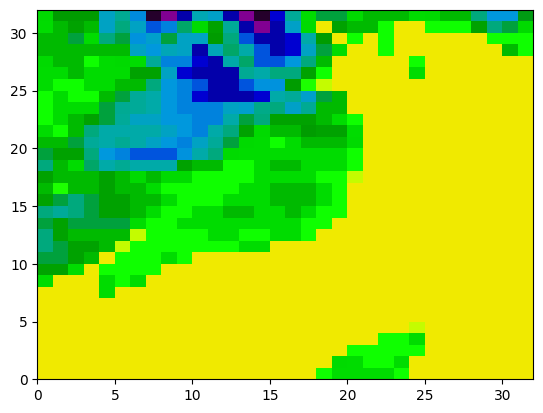

In [32]:
plt.pcolormesh(I_valid[0, ..., 0], vmin=-0.5, vmax=0.5, cmap=plt.cm.nipy_spectral_r)

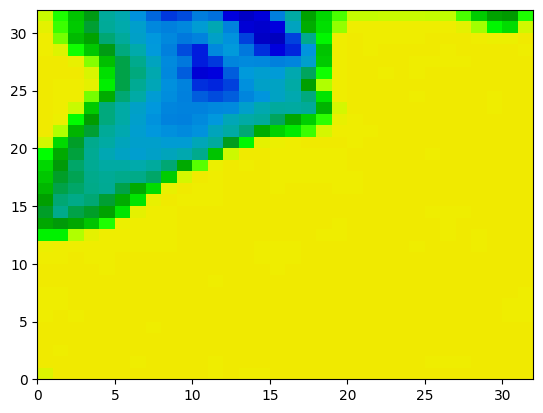

In [30]:
plt.pcolormesh(pred_[0, ..., 0], vmin=-0.5, vmax=0.5, cmap=plt.cm.nipy_spectral_r)

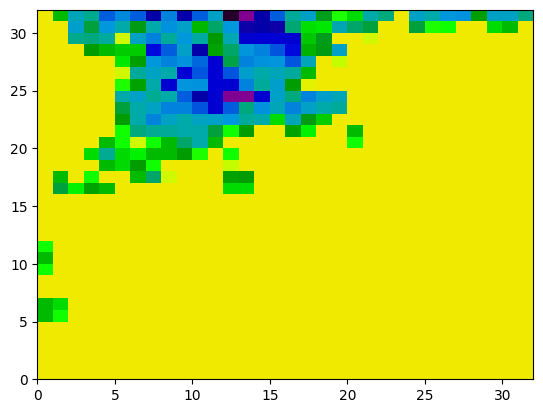

In [28]:
plt.pcolormesh(Y_valid[0, ..., 0], vmin=-0.5, vmax=0.5, cmap=plt.cm.nipy_spectral_r)

**out-of-box reverse diffusion tests**

In [ ]:
# x_in1 = images_valid
# x_in2 = X_valid

# x1 = x_in1[i, ...][None, ...]
# x2 = x_in2[i, ...][None, ...]
        
# for t in reversed(range(0, total_timesteps)):
#     tt = tf.cast(tf.fill(1, t), dtype=tf.int64)
#     pred_noise = model.predict([x1, tt, x2], verbose=0)
#     model_mean, _, model_log_variance =  gdf_util.p_mean_variance(pred_noise, x=x1, t=tt, clip_denoised=True)
#     nonzero_mask = (1 - (np.array(tt)==0)).reshape((1, 1, 1, 1))
#     x1 = np.array(model_mean) + nonzero_mask * np.exp(0.5 * np.array(model_log_variance)) * np.random.normal(size=x1.shape)